### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
import config

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=config.CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some image

Visualize some REAL images with their boxes for sanity checking 

Loaded 1449 image samples
Loaded 581 image samples


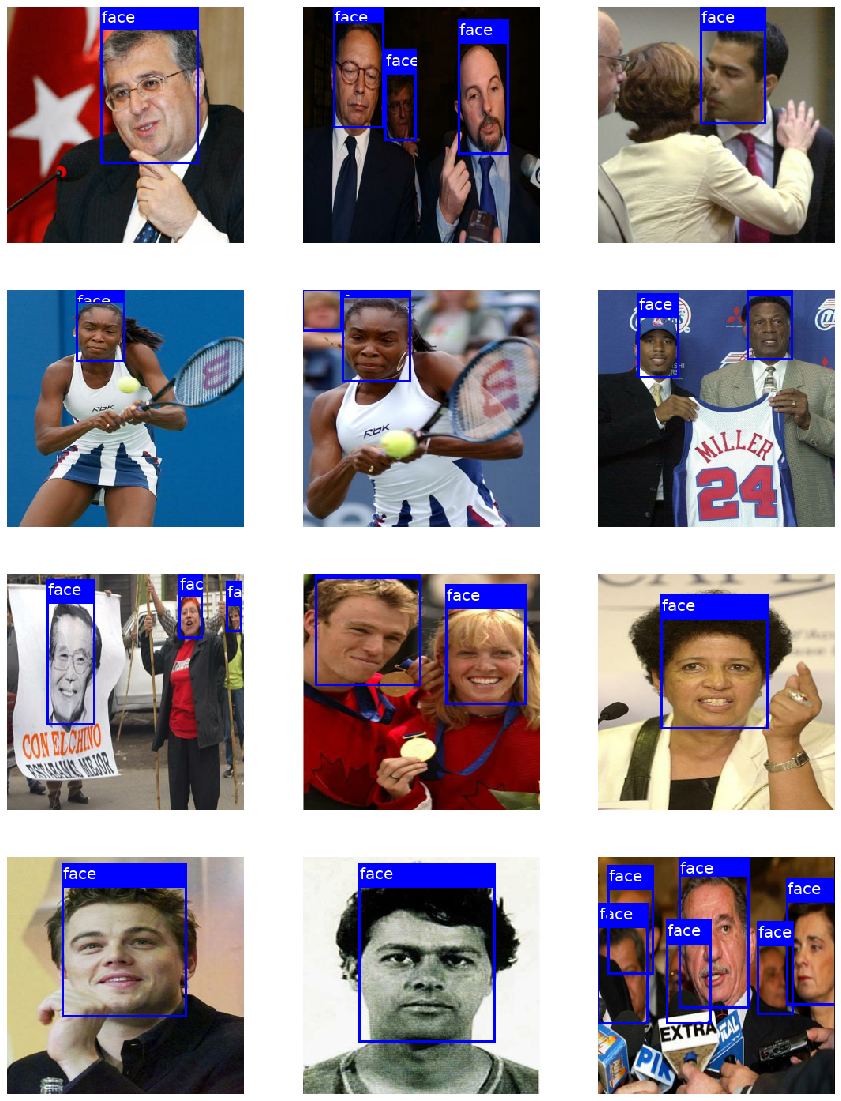

In [4]:
from faces_loader import load_faces, build_dataset

train_image_paths, train_bnd_boxes = load_faces(split='train')
valid_image_paths, valid_bnd_boxes = load_faces(split='valid')
data = build_dataset(train_image_paths, train_bnd_boxes,
                    image_size=config.IMAGE_SIZE)

num_display = 12
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(data)

for idx in range(num_display):
    x, y = next(data_iter)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

## MobileNet

### Instantiate the model

In [5]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(config.CLASSES), name='ssd_mobilenet')

### Create the data pipelines

In [6]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 2430, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [7]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_mobilenet.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS * 2,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 20.8310

Calculating Average Precision...: 92it [00:00, 874.89it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:00, 858.75it/s]


25/25 [==============================] - 24s 975ms/step - loss: 20.8310 - val_meanAP: 0.0112
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 4.1748

Calculating Average Precision...: 24it [00:00, 231.58it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 260.32it/s]


25/25 [==============================] - 31s 1s/step - loss: 4.1748 - val_meanAP: 0.3939
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 3.0496

Calculating Average Precision...: 36it [00:00, 349.86it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 321.50it/s]


25/25 [==============================] - 30s 1s/step - loss: 3.0496 - val_meanAP: 0.4448
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 2.4123

Calculating Average Precision...: 33it [00:00, 323.50it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 352.51it/s]


25/25 [==============================] - 26s 1s/step - loss: 2.4123 - val_meanAP: 0.5620
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 2.1825

Calculating Average Precision...: 38it [00:00, 379.65it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 334.27it/s]


25/25 [==============================] - 20s 814ms/step - loss: 2.1825 - val_meanAP: 0.5860
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 1.8730

Calculating Average Precision...: 38it [00:00, 379.08it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 343.33it/s]


25/25 [==============================] - 20s 802ms/step - loss: 1.8730 - val_meanAP: 0.6578
Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 1.6774

Calculating Average Precision...: 38it [00:00, 374.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 354.46it/s]


25/25 [==============================] - 20s 804ms/step - loss: 1.6774 - val_meanAP: 0.6705
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 1.4353

Calculating Average Precision...: 44it [00:00, 433.50it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 386.43it/s]


25/25 [==============================] - 20s 787ms/step - loss: 1.4353 - val_meanAP: 0.6815
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 1.4800

Calculating Average Precision...: 47it [00:00, 468.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 363.85it/s]


25/25 [==============================] - 20s 795ms/step - loss: 1.4800 - val_meanAP: 0.7094
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 1.2906

Calculating Average Precision...: 44it [00:00, 434.64it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 371.48it/s]


25/25 [==============================] - 20s 786ms/step - loss: 1.2906 - val_meanAP: 0.7220
Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 1.1580

Calculating Average Precision...: 46it [00:00, 458.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 408.58it/s]


25/25 [==============================] - 19s 774ms/step - loss: 1.1580 - val_meanAP: 0.7268
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 1.1265

Calculating Average Precision...: 43it [00:00, 424.03it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 361.32it/s]


25/25 [==============================] - 20s 793ms/step - loss: 1.1265 - val_meanAP: 0.7423
Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 1.0753

Calculating Average Precision...: 40it [00:00, 396.26it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 359.27it/s]


25/25 [==============================] - 20s 816ms/step - loss: 1.0753 - val_meanAP: 0.7589
Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 1.0077

Calculating Average Precision...: 36it [00:00, 359.88it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 402.02it/s]


25/25 [==============================] - 20s 812ms/step - loss: 1.0077 - val_meanAP: 0.7782
Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.9194

Calculating Average Precision...: 39it [00:00, 389.78it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 339.89it/s]


25/25 [==============================] - 20s 811ms/step - loss: 0.9194 - val_meanAP: 0.7788
Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.8563

Calculating Average Precision...: 43it [00:00, 407.24it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 357.84it/s]


25/25 [==============================] - 22s 878ms/step - loss: 0.8563 - val_meanAP: 0.7923
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.7986

Calculating Average Precision...: 34it [00:00, 329.28it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 275.82it/s]

25/25 [==============================] - 23s 912ms/step - loss: 0.7986 - val_meanAP: 0.7837


Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.8509

Calculating Average Precision...: 34it [00:00, 328.20it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 280.79it/s]


25/25 [==============================] - 23s 915ms/step - loss: 0.8509 - val_meanAP: 0.8015
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.7808

Calculating Average Precision...: 31it [00:00, 307.23it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 276.14it/s]

25/25 [==============================] - 24s 979ms/step - loss: 0.7808 - val_meanAP: 0.7911


Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.7267

Calculating Average Precision...: 31it [00:00, 309.63it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 267.04it/s]

25/25 [==============================] - 25s 983ms/step - loss: 0.7267 - val_meanAP: 0.7996


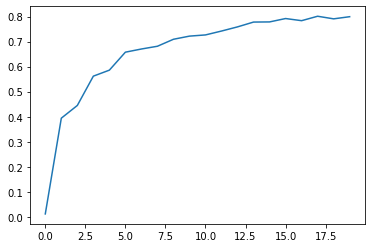

In [8]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 33it [00:00, 320.88it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 288.57it/s]


Validation meanAP: tf.Tensor(0.8014554876056866, shape=(), dtype=float64)


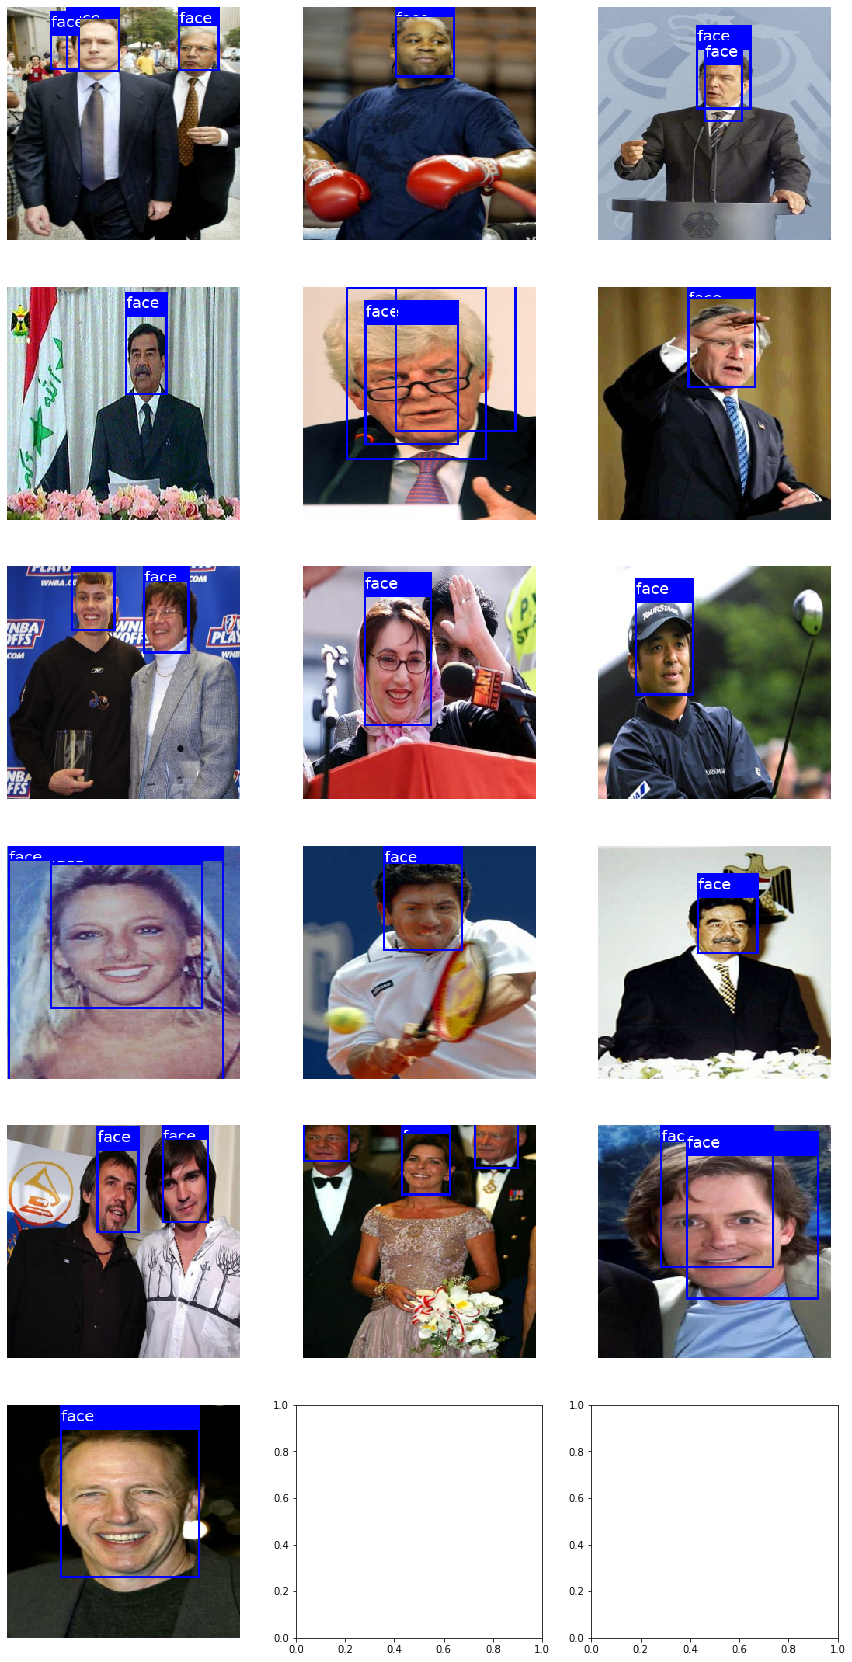

In [9]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_mobilenet.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [11]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(config.CLASSES), name='ssd_resnet50')

### Create the data pipelines

In [12]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 4149, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [17]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_resnet50.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20


KeyboardInterrupt: 

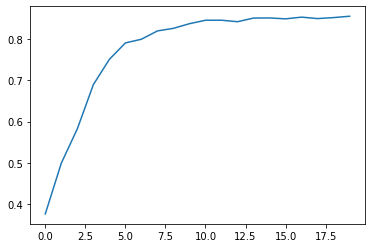

In [14]:
plt.plot(history.history['val_meanAP'])

In [16]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_resnet50.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

OSError: Unable to open file (unable to open file: name = 'baseline_resnet50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)